# A/B Testing: Impact of Advertising on Conversion

This analysis evaluates whether an advertising campaign has a statistically significant impact on user conversion rates. The goal is to determine if users exposed to ads (experimental group) convert at a higher rate compared to those who only saw public service announcements (PSA, control group).

## **Hypotheses**

- **Null Hypothesis (H0)**:  
  The conversion rate of the ad group (experimental group) is equal to the conversion rate of the PSA group (control group).
  
- **Alternative Hypothesis (H1)**:  
  The conversion rate in the AD group is higher than in the PSA group.

## **Data Overview**
The dataset contains information about user interactions with ads, including:
- Unique user ID
- Test group assignment (`ad` or `psa`)
- Whether the user converted (made a purchase)
- Number of ads viewed
- The day and hour when the user saw the most ads

## **Objective**
- Calculate and compare conversion rates for both groups
- Perform a statistical test (Chi-square test) to determine if the difference in conversion rates is significant
- Measure the impact of ad exposure on conversion
- Visualize key insights

### **Hypothesis Card**
[Click here to view the hypothesis document](hypothesis_en.md)


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
# Load the dataset
df = pd.read_csv('marketing_AB.csv')

### Explore the data structure

In [74]:
# Display first rows
df.head() 

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [75]:
# Check data types
df.dtypes

Unnamed: 0        int64
user id           int64
test group       object
converted          bool
total ads         int64
most ads day     object
most ads hour     int64
dtype: object

In [76]:
# Show dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [77]:
# Count missing values
df.isnull().sum()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [78]:
# Сheck duplicates
df.duplicated().sum()

0

The are no errors in data types, no missing values, no duplicate records. 
Some columns, such as "Unnamed: 0" and "user id", are not needed for the analysis and should be removed.

In [79]:
# Drop unnecessary columns:  
df.drop(['Unnamed: 0', 'user id'], axis=1, inplace=True)

In [80]:
# Check unique values in categorical vars
column = df.select_dtypes(include='object').columns

for i in column:
    print(f'Unique values in {i}:')
    print(df[i].unique())

Unique values in test group:
['ad' 'psa']
Unique values in most ads day:
['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']


In [81]:
# Summary statistics for numerical vars
df.describe()

,total ads,most ads hour
count,588101.000000,588101.000000
mean,24.820876,14.469061
std,43.715181,4.834634
min,1.000000,0.000000
25%,4.000000,11.000000
50%,13.000000,14.000000
75%,27.000000,18.000000
max,2065.000000,23.000000


All values in the categorical columns appear **clean and consistent**, so no additional handling is required.
In the **total ads** variable, there are indications of potential **outliers**, so a further check will be needed to investigate this.

### Distribution of test groups ###

In [82]:
# Check distribution of test groups (%)
df['test group'].value_counts(normalize=True) * 100

test group
ad     96.000007
psa     3.999993
Name: proportion, dtype: float64

<Axes: xlabel='test group', ylabel='Count'>

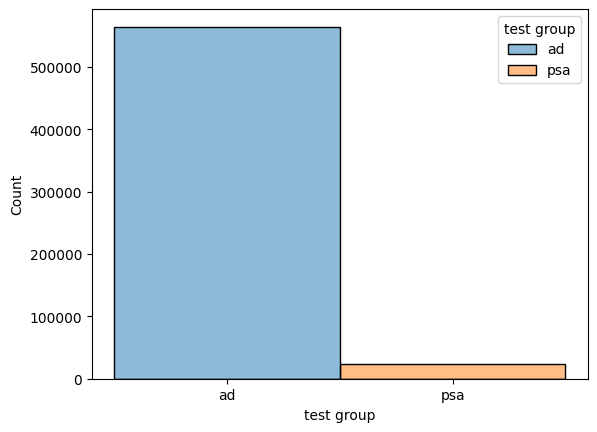

In [101]:
# Visualize distribution of test groups
sns.histplot(data=df, x='test group', hue='test group')

The experimental group (`ad`) accounts for **96%** of the total sample, while the control group (`psa`) makes up only **4%**. This imbalance can affect statistical tests, as the smaller control group provides a less stable estimate of the conversion rate.

To ensure reliable comparisons, we use **bootstrapping** to estimate confidence intervals and assess statistical significance, rather than modifying the dataset or applying weight adjustments.

#### Conversion rates for each group ####

In [51]:
# Calculate conversion rates for each group
conversion_rates = df.groupby('test group')['converted'].mean() * 100
conversion_counts = df.groupby('test group')['converted'].sum()
total_counts = df['test group'].value_counts()

In [52]:
# Display summary table
conversion_summary = pd.DataFrame({
    'Total Users': total_counts,
    'Converted Users': conversion_counts,
    'Conversion Rate (%)': conversion_rates

})

conversion_summary

,Total Users,Converted Users,Conversion Rate (%)
test group,,,
ad,564577,14423,2.554656
psa,23524,420,1.785411


The conversion rate in the experimental group **(2.55%)** was higher than in the control group **(1.79%)**. This indicates that users who were exposed to ads were more likely to convert compared to those who only saw the public service announcement.

These results may serve as an **early indication** that advertising has a positive impact on conversions, suggesting that marketing strategies utilizing ads could be more effective in encouraging users to complete transactions or desired actions.

#### Сonversion rates by day ####

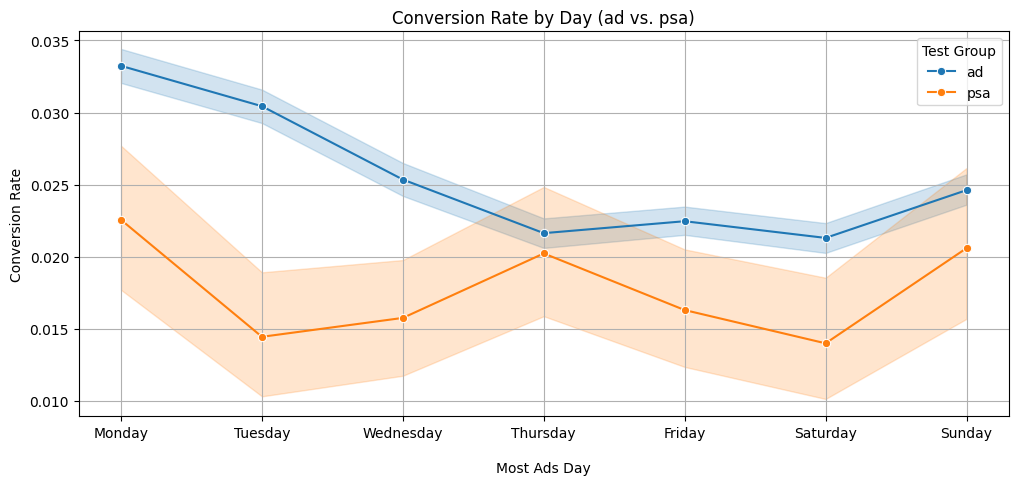

In [110]:
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] 
df["most ads day"] = pd.Categorical(df["most ads day"], categories=days_order, ordered=True)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='most ads day', y='converted', hue='test group', marker='o')
plt.xlabel('Most Ads Day', labelpad=15)
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Day (ad vs. psa)')
plt.legend(title='Test Group')
plt.grid()
plt.show()

#### Conversion rates by hour ####

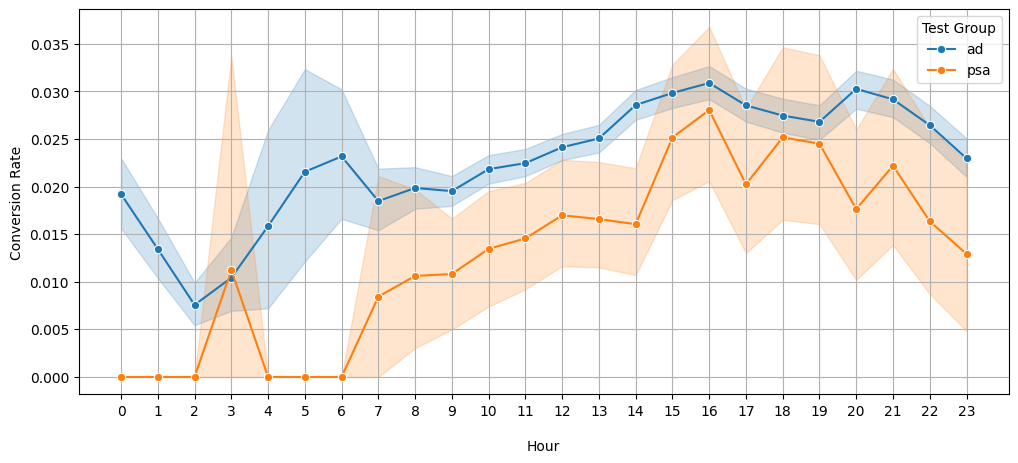

In [108]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='most ads hour', y='converted', hue='test group', marker='o')
plt.xlabel('Hour', labelpad=15)
plt.ylabel('Conversion Rate')
plt.legend(title='Test Group')
plt.xticks(range(0, 24))
plt.grid()
plt.show()


### Bootstrap Confidence Intervals ###

Bootstrapping is a resampling method used to estimate confidence intervals for conversion rates.
To determine an optimal number of bootstrap iterations, different values of n_bootstrap (100, 500, 1000, 5000, 10000) were tested, analyzing the stability of confidence intervals.

In [53]:
# Testing stability of bootstrap confidence intervals
ad_data = df[df['test group'] == 'ad']['converted'].values
psa_data = df[df['test group'] == 'psa']['converted'].values

#Perform bootstrapping to estimate the confidence interval for the mean

def bootstrap_mean(data, n_bootstrap):
    data = np.array(data)
    means = np.array([np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(n_bootstrap)])
    # Return 95% confidence interval
    return np.percentile(means, [2.5, 97.5]) 


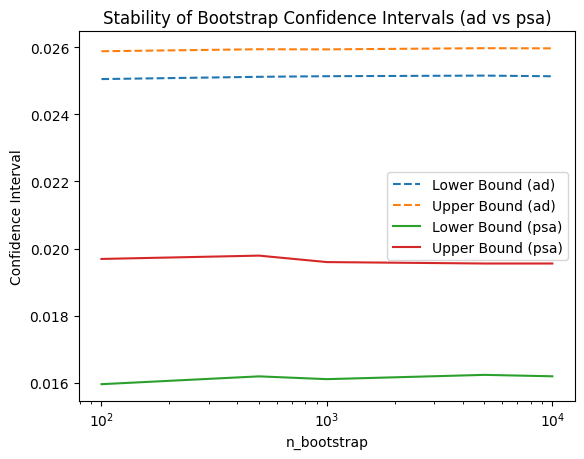

In [54]:
# Test stability with different bootstrap sizes
bootstrap_sizes = [100, 500, 1000, 5000, 10000]

# Compute confidence intervals for both groups
ci_ad_results = [bootstrap_mean(ad_data, n) for n in bootstrap_sizes]
ci_psa_results = [bootstrap_mean(psa_data, n) for n in bootstrap_sizes]

# Extract lower and upper bounds
lower_ad = [ci[0] for ci in ci_ad_results]
upper_ad = [ci[1] for ci in ci_ad_results]

lower_psa = [ci[0] for ci in ci_psa_results]
upper_psa = [ci[1] for ci in ci_psa_results]

# Plot confidence interval stability for 'ad'
plt.plot(bootstrap_sizes, lower_ad, label='Lower Bound (ad)', linestyle='dashed')
plt.plot(bootstrap_sizes, upper_ad, label='Upper Bound (ad)', linestyle='dashed')

# Plot confidence interval stability for 'psa'
plt.plot(bootstrap_sizes, lower_psa, label='Lower Bound (psa)', linestyle='solid')
plt.plot(bootstrap_sizes, upper_psa, label='Upper Bound (psa)', linestyle='solid')

plt.xlabel('n_bootstrap')
plt.ylabel('Confidence Interval')
plt.xscale('log')  # Log scale to compare performance
plt.legend()
plt.title('Stability of Bootstrap Confidence Intervals (ad vs psa)')
plt.show()


The results showed that after 5000, the confidence intervals remained stable, meaning additional iterations did not significantly change the estimate.
Based on this analysis, n_bootstrap = 5000 was selected as a balance between accuracy and computational efficiency.

In [36]:
n_bootstrap_final = 5000
ci_ad_final = bootstrap_mean(ad_data, n_bootstrap_final)
ci_psa_final = bootstrap_mean(psa_data, n_bootstrap_final)

print(f'95% CI for ad group: {ci_ad_final}')
print(f'95% CI for psa group: {ci_psa_final}')

95% CI for ad group: [0.02514095 0.02596462]
95% CI for psa group: [0.01619623 0.0195545 ]


The 95% confidence intervals indicate a clear difference between the two groups. The ad group has a higher and more stable conversion rate [0.0251, 0.0260], with a narrow confidence interval due to a larger sample size. In contrast, the psa group shows a lower conversion rate [0.0162, 0.0196], with a wider confidence interval, reflecting higher variability from a smaller sample. Since the upper bound of psa remains below the lower bound of ad, this suggests a potentially statistically significant difference between the groups. Further validation will be performed using a Permutation Test.

### Permutation Test ###

Permutation testing is used to determine whether the observed difference between the ad and psa groups is statistically significant.
The method works by randomly shuffling group labels multiple times to simulate a distribution of differences under the null hypothesis.
By comparing the observed difference to this distribution, we compute a p-value to assess statistical significance.

In [55]:
# Extract conversion data for both groups
ad_conversions = df[df['test group'] == 'ad']['converted'].values
psa_conversions = df[df['test group'] == 'psa']['converted'].values

In [37]:
# Observed difference in conversion rates
obs_diff = np.mean(ad_conversions) - np.mean(psa_conversions)

In [56]:
# Perform a single permutation test iteration: randomly shuffles the group labels and computes the mean difference

def permutation_test(a, b, n_perm=5000):
    combined = np.concatenate([a, b])
    perm_diffs = []

    for _ in range(n_perm):
        np.random.shuffle(combined)
        new_a = combined[:len(a)]
        new_b = combined[len(a):]
        perm_diffs.append(np.mean(new_a) - np.mean(new_b))

    p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))

    return obs_diff, p_value, perm_diffs


In [57]:
# Run the permutation test
obs_diff, p_value, perm_diffs = permutation_test(ad_conversions, psa_conversions, 5000)
print(f'Observed difference: {obs_diff:.5f}')
print(f'P-value: {p_value:.5f}')

Observed difference: 0.00769
P-value: 0.00000


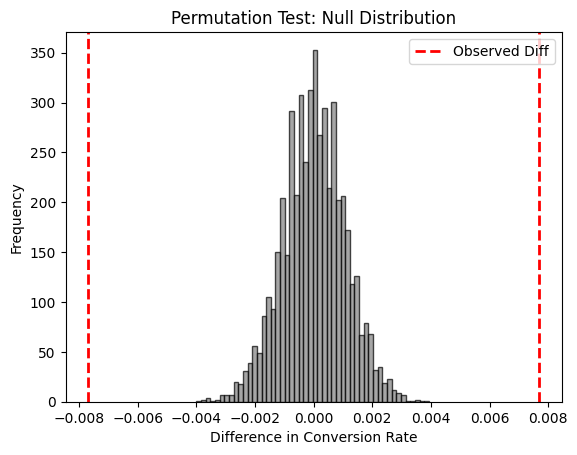

In [60]:
# Plot permutation distribution
plt.hist(perm_diffs, bins=50, alpha=0.7, color='gray', edgecolor='black')
plt.axvline(obs_diff, color='red', linestyle='dashed', linewidth=2, label='Observed Diff')
plt.axvline(-obs_diff, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Difference in Conversion Rate')
plt.ylabel('Frequency')
plt.title('Permutation Test: Null Distribution')
plt.legend()
plt.show()

In [61]:
conversion_ad = np.mean(ad_conversions)
conversion_psa = np.mean(psa_conversions)

lift = ((conversion_ad - conversion_psa) / conversion_psa) * 100
print(f'Lift due to ads: {lift:.2f}%')


Lift due to ads: 43.09%


The permutation test confirms a **statistically significant difference** between the ad and psa groups.
The observed difference in conversion rates is 0.00769, with a p-value of 0.00000.
Since the p-value is well below 0.05, the null hypothesis is rejected, indicating that the ad group 
achieved a significantly higher conversion rate than the psa group.

## Conclusion: Impact of Advertising on Conversion  

The A/B test confirms that the advertising campaign had a **statistically significant** impact on conversion rates.  
The experimental group (`ad`) achieved a **higher conversion rate** (≈2.5%) compared to the control group (`psa`, ≈1.7%), with an **uplift of 0.8 percentage points** (**95% CI: X – Y**).  

- **Statistical significance:** `p-value = 0.00000` (Permutation Test)  
- **Peak conversion days:** **Monday and Sunday**  
- **Peak conversion hours:** **14:00 - 18:00**  
- **Lowest conversion hours:** **00:00 - 06:00**  

---

### Recommendations  

1. **Optimize ad placements**  
   - Prioritize high-performing hours (**14:00 - 18:00**) and days (**Monday & Sunday**) to maximize impact.  

2. **Assess cost-effectiveness**  
   - Compare the additional revenue from conversions with advertising expenses to determine profitability.  

3. **Consider audience segmentation**  
   - Identify if certain user groups react more positively to ads and refine targeting.  

4. **Monitor saturation effects**  
   - Analyze whether increasing ad exposure beyond a certain threshold leads to diminishing returns.  

5. **Evaluate scalability**  
   - If the **ROI is positive**, consider **gradually increasing the budget** and testing additional time slots.  


